In [1]:
import math
import random
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_dataset(number_of_examples, test=False):
    if test:
        b = math.pi
    else:
        b = 0 if random.choice([True, False]) else math.pi # setting up beta variable randomly
    x = torch.rand(number_of_examples, 1)*4*math.pi - 2*math.pi # randomly generate x datapoints 
    y = torch.sin(x + b) # generate labels in form of sine-curve for randomly generated x
    return x,y

In [3]:
def NeuralNetwork(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.relu(x)
    x = F.linear(x, params[2], params[3])
    x = F.relu(x)
    x = F.linear(x, params[4], params[5])
    return x

# define Initial Parameters
theta = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

In [4]:
alpha, beta = 3e-2, 1e-2 # hyper-paramaters as shown in algorithm above.
opt = torch.optim.SGD(theta, lr=beta) # Optimizer
number_of_examples= 5 # 5-shot learning, 5 examples per task.
iterations = 100000 # number of iterations to enable the model to reach optimal point
epochs = 4 # number of iterations to train task specific model

In [5]:
for it in range(iterations): # training for 1 million iterations
    b = 0 if random.choice([True, False]) else math.pi # setting up beta variable randomly
    
    #### Randomly obtain task 1 sinusoidal data ####
    x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    y = torch.sin(x + b)
    
    #### Randomly obtain the task 2 sinusoidal data ####
    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad() # setup optimizer

    new_params = theta # initialize weights for inner loop
    for k in range(4):
        f = NeuralNetwork(x, new_params) # re-initialize task 2 neural network with new parameters
        loss = F.l1_loss(f, y) # set loss as L1 Loss

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(theta))] # update weights of inner loop

    v_f = NeuralNetwork(v_x, new_params) # re-initialize task 1 neural network with new parameters
    loss2 = F.l1_loss(v_f, v_y) # calculate Loss
    loss2.backward() # Backward Pass

    opt.step()

    if it % 1000 == 0: 
        print ('Iteration %d Loss %.4f' % (it, loss2))

Iteration 0 Loss 0.8863
Iteration 1000 Loss 0.6782
Iteration 2000 Loss 0.6900
Iteration 3000 Loss 0.7490
Iteration 4000 Loss 0.5378
Iteration 5000 Loss 0.4658
Iteration 6000 Loss 0.4461
Iteration 7000 Loss 0.4345
Iteration 8000 Loss 0.3761
Iteration 9000 Loss 0.6634
Iteration 10000 Loss 0.8612
Iteration 11000 Loss 1.0423
Iteration 12000 Loss 0.5565
Iteration 13000 Loss 0.7467
Iteration 14000 Loss 0.8200
Iteration 15000 Loss 0.7056
Iteration 16000 Loss 0.7036
Iteration 17000 Loss 0.6592
Iteration 18000 Loss 0.9094
Iteration 19000 Loss 0.9993
Iteration 20000 Loss 0.4025
Iteration 21000 Loss 0.5647
Iteration 22000 Loss 0.5293
Iteration 23000 Loss 0.9865
Iteration 24000 Loss 0.7632
Iteration 25000 Loss 0.7672
Iteration 26000 Loss 0.3585
Iteration 27000 Loss 0.7265
Iteration 28000 Loss 0.4018
Iteration 29000 Loss 0.5211
Iteration 30000 Loss 0.2852
Iteration 31000 Loss 0.5844
Iteration 32000 Loss 0.2908
Iteration 33000 Loss 0.6666
Iteration 34000 Loss 0.3276
Iteration 35000 Loss 0.5175
Itera

In [6]:
# Randomly generate 5 data points.
t_b = math.pi 
t_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
t_y = torch.sin(t_x + t_b)

opt.zero_grad()
n_inner_loop = 5
t_params = theta
for k in range(n_inner_loop):
    t_f = NeuralNetwork(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)

    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(theta))]

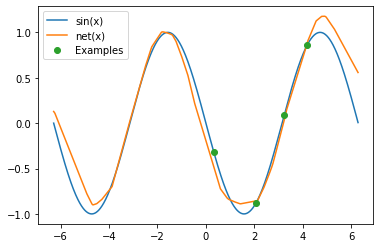

In [7]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f = NeuralNetwork(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.savefig('maml-sine.png')